In [8]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal,MultivariateNormal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [9]:
import gc
gc.collect()

2353

In [10]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Tue Jul  9 16:35:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 46%   65C    P2             224W / 250W |   6464MiB / 11264MiB |     94%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim,init_w=3e-3,log_std_min=-20,log_std_max=2):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)


        self.fc2 = nn.Linear(32, 32)
        self.log_std = nn.Linear(32, output_dim)
        self.mu=nn.Linear(32,output_dim)
        self.log_std_min=log_std_min
        self.log_std_max=log_std_max
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.mu.weight.data.uniform_(-init_w,init_w)
        self.mu.bias.data.uniform_(-init_w,init_w)
        self.log_std.weight.data.uniform_(-init_w,init_w)
        self.log_std.bias.data.uniform_(-init_w,init_w)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu(x) # Only apply if action bounds are [-1, 1]
        log_std = self.log_std(x)  # Ensure std is positive
        log_std=torch.clamp(log_std,self.log_std_min,self.log_std_max)

        return mu, log_std


Using device: cuda


In [12]:
from imitation.util.util import make_vec_env

observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)

observations=observations.squeeze()
actions=actions.squeeze()

print(observations.shape, actions.shape)

# env=gym.make("HalfCheetah-v3",render_mode="rgb_array")
# env=make_vec_env("", n_envs=1, seed=0, render_mode="rgb_array")
env = make_vec_env(
    "seals:seals/Ant-v1",
    rng=np.random.default_rng(42),
    n_envs=1,
)




(5000, 29) (5000, 8)


In [13]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [14]:
policy_network = PolicyNetwork(29,8).to(device)
prev = PolicyNetwork(29,8).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0003,weight_decay=1e-4)

# Training loop
num_epochs = 40
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
greedy_rewards=[]
sample_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
prev_load_freq = 32
now_log=0
now_pos=0
greedy_score=0
sample_score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        mu, log_std = policy_network(obs_batch)
        std=log_std.exp()
        dist = Normal(mu, std)
        z_model=dist.rsample()
        model_action=torch.tanh(z_model)
        z_expert=torch.atanh(torch.clamp(act_batch, -0.999999, 0.999999))
        epsilon=1e-6


        policy_rejected_logps =dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
        policy_chosen_logps = dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        with torch.no_grad():
          prev_mu, prev_log_std = prev(obs_batch)
          prev_std=prev_log_std.exp()
          prev_dist = Normal(prev_mu, prev_std)

          reference_rejected_logps =prev_dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
          reference_chosen_logps = prev_dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps
        logits = pi_logratios - ref_logratios
        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

       

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch < -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 0.1
          losses=-F.logsigmoid(beta * logits)
          loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        #   loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()


        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)



        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            for _ in range(num_test):
                state= env.reset()
                done = False

                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(mu)   
                        action.squeeze_()

                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward
                    # frames.append(env.render())
            image_path=f"{epoch}.gif"
            # imageio.mimsave("./gif/greedy/"+image_path, frames)

            greedy_score=total_reward/num_test
            total_reward=0
            frames = []
            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(Normal(mu,std).sample())
                        action.squeeze_()
                       
                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward
                    # frames.append(env.render())
            image_path=f"{epoch}.gif"
            # imageio.mimsave("./gif/sample/"+image_path, frames)

            sample_score=total_reward/num_test
            greedy_rewards.append(greedy_score)
            sample_rewards.append(sample_score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward,"greedy_score":greedy_score,"sample_score":sample_score})
    prev.load_state_dict(policy_network.state_dict())
    prev.eval()
         

env.close()

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/40]:  97%|█████████▋| 152/157 [00:03<00:00, 55.82it/s, loss=0.681, positive_reward=0.457, negative_reward=0.204, margin=0.252, greedy_score=0, sample_score=0]   /tmp/ipykernel_800537/1315175968.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [40/40]: 100%|██████████| 157/157 [01:19<00:00,  1.97it/s, loss=0.693, positive_reward=0.0197, negative_reward=0.0156, margin=0.00411, greedy_score=[974.7521], sample_score=[193.6147]]   


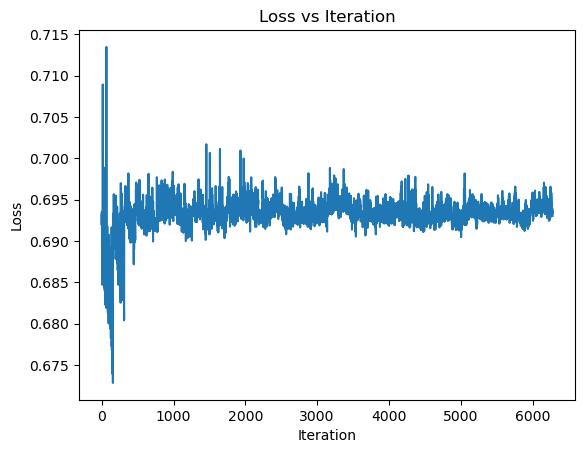

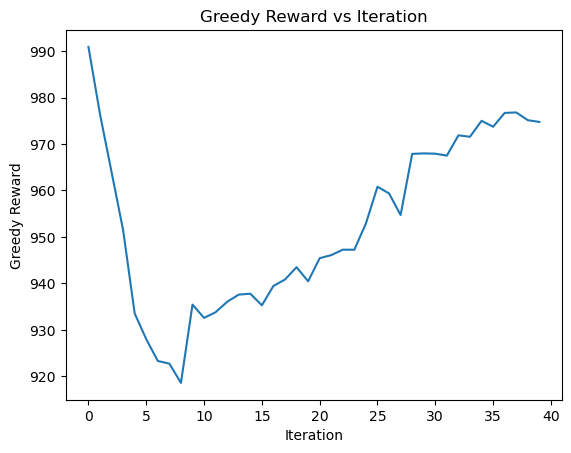

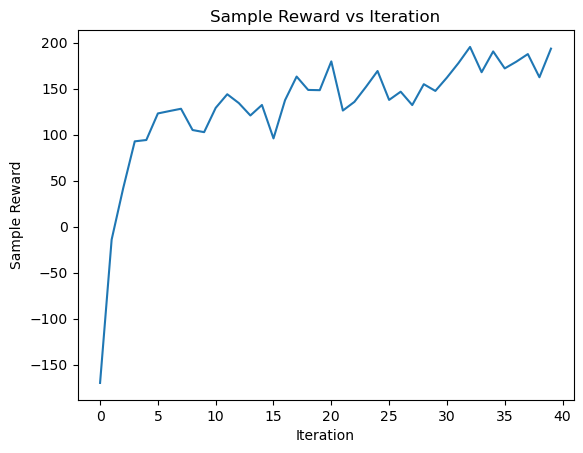

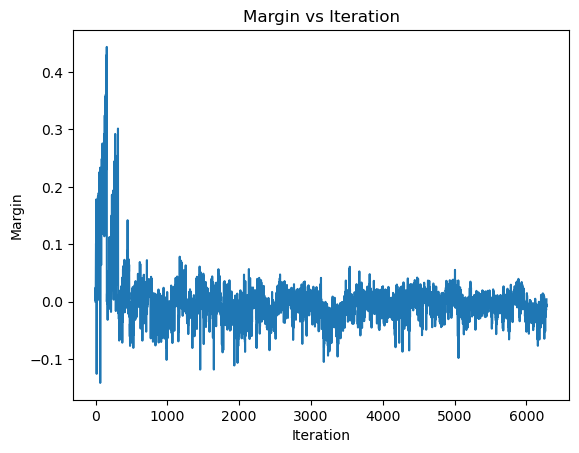

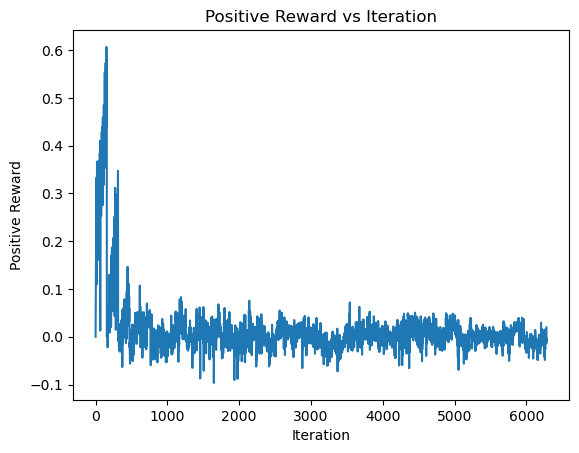

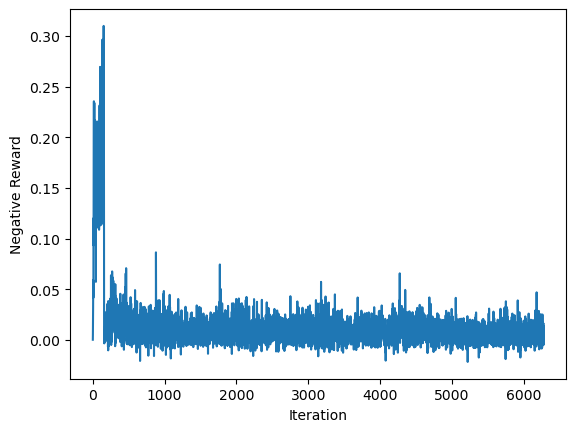

In [15]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
# plt.savefig("./loss.png")

plt.show()



# draw the reward graph
plt.plot(greedy_rewards)
plt.xlabel("Iteration")
plt.ylabel("Greedy Reward")
plt.title("Greedy Reward vs Iteration")
# plt.savefig("./greedy_reward.png")
plt.show()

# draw the reward graph
plt.plot(sample_rewards)
plt.xlabel("Iteration")
plt.ylabel("Sample Reward")
plt.title("Sample Reward vs Iteration")
# plt.savefig("./sample_reward.png")
plt.show()


# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
# plt.savefig("./margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
# plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
# plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()
# save to csv
df = pd.DataFrame(list(zip(loss_graph,greedy_rewards,sample_rewards,margin_graph,positive_reward_graph,negative_reward_graph)),columns=["loss","greedy_rewards","sample_rewards","margin","positive_reward","negative_reward"])
df.to_csv("log.csv",index=False)



In [16]:
# policy_network = PolicyNetwork(18,6).to(device)
# prev = PolicyNetwork(18,6).to(device)
# prev.load_state_dict(policy_network.state_dict())
# prev.eval()

# optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0003,weight_decay=1e-4)

# Training loop
num_epochs = 50
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# loss_graph=[]
# greedy_rewards=[]
# sample_rewards=[]
# margin_graph=[]
# positive_reward_graph=[]
# negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
prev_load_freq = 32
now_log=0
now_pos=0
greedy_score=0
sample_score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        mu, log_std = policy_network(obs_batch)
        std=log_std.exp()
        dist = Normal(mu, std)
        z_model=dist.rsample()
        model_action=torch.tanh(z_model)
        z_expert=torch.atanh(torch.clamp(act_batch, -0.999999, 0.999999))
        epsilon=1e-6


        policy_rejected_logps =dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
        policy_chosen_logps = dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        with torch.no_grad():
          prev_mu, prev_log_std = prev(obs_batch)
          prev_std=prev_log_std.exp()
          prev_dist = Normal(prev_mu, prev_std)

          reference_rejected_logps =prev_dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
          reference_chosen_logps = prev_dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps
        logits = pi_logratios - ref_logratios
        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

       

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch < -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 0.1
          losses=-F.logsigmoid(beta * logits)
          loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        #   loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()


        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)



        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            for _ in range(num_test):
                state= env.reset()
                done = False

                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(mu)   
                        action.squeeze_()

                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward
                    # frames.append(env.render())
            image_path=f"{epoch}.gif"
            # imageio.mimsave("./gif/greedy/"+image_path, frames)

            greedy_score=total_reward/num_test
            total_reward=0
            frames = []
            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(Normal(mu,std).sample())
                        action.squeeze_()
                       
                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward
                    # frames.append(env.render())
            image_path=f"{epoch}.gif"
            # imageio.mimsave("./gif/sample/"+image_path, frames)

            sample_score=total_reward/num_test
            greedy_rewards.append(greedy_score)
            sample_rewards.append(sample_score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward,"greedy_score":greedy_score,"sample_score":sample_score})
    prev.load_state_dict(policy_network.state_dict())
    prev.eval()
         

env.close()

Epoch [1/50]:   0%|          | 0/157 [00:00<?, ?it/s, loss=0.695, positive_reward=-.0226, negative_reward=0.00886, margin=-.0315, greedy_score=0, sample_score=0]   

Epoch [50/50]: 100%|██████████| 157/157 [01:14<00:00,  2.12it/s, loss=0.693, positive_reward=0.00554, negative_reward=0.00757, margin=-.00203, greedy_score=[980.28644], sample_score=[160.09985]]
